In [1]:
import requests
import urllib
import pandas as pd
import traceback
# USGS Elevation Point Query Service
url = r'https://nationalmap.gov/epqs/pqs.php?'

# coordinates with known elevation 
lat = [48.633, 48.733, 45.1947, 45.1962]
lon = [-93.9667, -94.6167, -93.3257, -93.2755]

# create data frame
df = pd.DataFrame({
    'lat': lat,
    'lon': lon
})

def elevation_function(df, lat_column, lon_column):
    """Query service using lat, lon. add the elevation values as a new column."""
    elevations = []
    for lat, lon in zip(df[lat_column], df[lon_column]):

        # define rest query params
        params = {
            'output': 'json',
            'x': lon,
            'y': lat,
            'units': 'Meters'
        }

        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])

    df['elev_meters'] = elevations

#elevation_function(df, 'lat', 'lon')
df.head()

,lat,lon
0,48.6330,-93.9667
1,48.7330,-94.6167
2,45.1947,-93.3257
3,45.1962,-93.2755


In [2]:
 # define rest query params
params = {
    'output': 'json',
    'x': -93.9667,
    'y': 48.633,
    'units': 'Meters'
}

# format query string and return query value
#result = requests.get((url + urllib.parse.urlencode(params)))
#result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation']

In [3]:
"""
OBJETIVO: Centralizar los resultados, generar metricas adecuadas a cada modelo para luego poder compararlos.
          De esta forma obtener el modelo mas adecuado para el proyecto.
"""
Autor='Diego Paredes'

In [4]:
"""
from netCDF4 import Dataset, num2date
import cartopy.crs as ccrs
import cartopy.feature as cf
"""

from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.utils import shuffle
#from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import hiplot as hip
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets


#import re
import numpy as np
import glob
import time
import os

In [5]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes'

In [6]:
def crearDir(path, newDir):
    try:
        pathT = os.path.join(path, newDir)
        os.mkdir(pathT)
        return pathT
    except FileExistsError:
        return pathT
        pass
    except:
        print(f"No se pudo crear el directorio: {newDir}")
        pritn(f'Path base: {path}')
        pritn(f'Nuevo    : {newDir}')        
        return None

In [7]:
def analizarProject(path_base,project ,df= None):
    if not df:
        df = pd.read_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/Clasificacion/Reporte-TOTAL.csv')    
    df = df[df['idTest']==project] 
    
    """ GRAFICA DE LOSS """
    fig = go.Figure()    
    fig.add_trace( go.Scatter(mode='lines',x=df["epoca"], y=df["loss"], name='Train')) 
    fig.add_trace( go.Scatter(mode='lines',x=df["epoca"], y=df["val_loss"], name='Valid')) 
    fig.update_layout(title={'text':'Grafica de Loss por epoca'}, xaxis={'title': 'EPOCAS'},
                      yaxis={'title': 'LOSS'})
    fig.show()       
    
    """ GRAFICA DE ACC BAL """       

    fig = go.Figure()    
    fig.add_trace( go.Scatter(mode='lines',x=df["epoca"], y=df["train_acc_bal"], name='Train')) 
    fig.add_trace( go.Scatter(mode='lines',x=df["epoca"], y=df["acc_bal"], name='Valid')) 
    fig.update_layout(title={'text':'Grafica de Balanced Acc por epoca'}, xaxis={'title': 'EPOCAS'},
                      yaxis={'title': 'BAL_ACC'})
    fig.show() 
  
    return None            

In [8]:
def graficaClasificacion(df, limites=[[0,1],[0,1]], name='V1' ,cuadrantes = True, legenda =True, train=False, legendName=[True,'idTest'], cant=0):
    
    """ GRAFICA DE DISPERSION """ 
    if not cant:
        cant = len(df)
    for j in df[:cant].index: 
        if train:
            x = df['train_TNR'][j]
            y = df['train_TPR'][j]  
        else:
            x = df['TNR'][j]
            y = df['TPR'][j]
        plt.plot(x,y , marker='o',label = f"{df[legendName[1]][j]}")              
    
    if legendName[0]:
        plt.legend(loc=(1.1,-0.1), title= 'Label')

    """ CUADRANTES Y LIMITES """
    x = np.linspace(0, 1, 100)
    plt.plot(x, x + 0, '--r')  
    if cuadrantes:
        plt.plot(x, [0.5]*100, '--k')  
        plt.plot([0.5]*100, x, '--k') 
    
    plt.xlim(limites[0][0],limites[0][1])
    plt.ylim(limites[1][0],limites[1][1])
    
    """ LEGENDA """
    if train:
        plt.title(f'Scatter TPR vs TNR (Train Data)')
    else:
        plt.title('Grafica de TPR vs TNR (Validacion)') #(f'Scatter TPR vs TNR (Validation Data)')
    plt.ylabel('TPR (C02)')
    plt.xlabel('TNR (M02)')
    plt.grid(linestyle='--')

    #plt.savefig(f'{path_base}/Archivos/Reportes/Plots/ClasificacionModeloComparacion.png')

    plt.show()

In [9]:
import re

In [10]:
# Reune los resultados de los diferentes archivos (Requiere tipo de modelo en params)
def summaryResultsFile(path_base, params):
    resultados = {}
    
    """ OBTENEMOS LOS ARCHIVOS DE RESULTADOS """
    model = params['model']
    modelPath = f'{params["resultDir"]}/'   
    os.chdir(modelPath)
    listFiles = list(glob.glob('**/**/*.xlsx'))
    #listFiles= listFiles[:-3]

    results = pd.DataFrame()
    projects = pd.DataFrame()
    
    """ RECORREMOS LOS ARCHIVOS EXCEL DE RESULTADOS """
    for file in listFiles:        
        """ VARIABLES GENERALES """
        try:
            dfGeneral = pd.read_excel(file, sheet_name='Informacion', nrows=1, keep_default_na=False)
        except Exception:
            print(file)
            print(traceback.format_exc())           
            return
        idProject = file.split('-')[-1].split('.')[0]
        dfGeneral['idProject']=idProject        
        projects = pd.concat([projects,dfGeneral],axis=0,ignore_index=True)
        
        
        dfHP = pd.read_excel(file, sheet_name='Informacion', skiprows=3)               
        dfTestParams = pd.read_excel(file, sheet_name='Informacion', nrows=3) 
        excelTemp = pd.read_excel(file,sheet_name=None)
        
        """ RECORREMOS LAS HOJAS DE CADA EXCEL """
        for k,v in excelTemp.items():
            if k != 'Informacion':
                # Numero Y ID de la prueba
                numT, idTest = k.split('-')
                dfTemp = excelTemp[k]
                # Hiperparametros de la prueba
                dfTemp['epoca'] = dfTemp['Unnamed: 0']
                dfTemp['idTest'] = idTest
                dfTemp['idProject'] = idProject
                dfTemp['directory'] = dfTestParams['directory']
                
                for iC in dfHP.columns[1:]:
                    dfTemp[f'P-{iC}'] = dfHP.loc[[int(numT)]][iC].iloc[0]
                    
                
                # Datos dependiente del modelo
                if model == 'Clasificacion':    
                    dfTemp.columns = [re.sub('[0-9]','',x) for x in dfTemp.columns]
              
                    dfTemp['TNR'] = dfTemp['val_TN'] / (dfTemp['val_TN']+dfTemp['val_FP']) # Recall de la clase 0 (M02)
                    dfTemp['TPR'] =    dfTemp['val_TP'] / (dfTemp['val_TP']+dfTemp['val_FN'])  # Recall de la clase 1 (C02)
                    
                    dfTemp['FDR'] = dfTemp['val_FP'] / (dfTemp['val_FP']+dfTemp['val_TP']) # False discovery rate
                    dfTemp['FOR'] = dfTemp['val_FN'] / (dfTemp['val_FN']+dfTemp['val_TN']) # False discovery rate
                    dfTemp['FDR_FOR'] =  (dfTemp['FDR'] + dfTemp['FOR']) / 2 
                    
                    dfTemp['acc_bal'] =  (dfTemp['TNR'] + dfTemp['TPR']) / 2 
                    
                    
                    dfTemp['train_TNR'] = dfTemp['TN'] / (dfTemp['TN']+dfTemp['FP']) # Recall de la clase 0 (M02)
                    dfTemp['train_TPR'] =    dfTemp['TP'] / (dfTemp['TP']+dfTemp['FN'])  # Recall de la clase 1 (C02)
                    dfTemp['train_acc_bal'] =  (dfTemp['train_TNR'] + dfTemp['train_TPR']) / 2        
                    
                    dfTemp['avg_acc_bal'] =  (dfTemp['train_acc_bal'] + dfTemp['acc_bal']) / 2        
                    
                elif model== 'Regresion':
                    pass
                else:
                    print(f'ERROR: No se encuentra el tipo de modelo {model}')
                
                # Reunimos los resultados
                results = pd.concat([results,dfTemp],axis=0,ignore_index=True)
    results = results.fillna(0)
    """ GRABAMOS LOS RESULTADOS """
    results.to_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/{model}/Reporte-TOTAL.csv',index=False)
    projects.to_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/{model}/Proyectos.csv',index=False)
   
    return results


In [11]:
# Obteine el mejor resultado de un conjunto de epocas segun criterio (params)
def summaryStats(path_base, params):      
    model = params['model']
    
    """ REUNIMOS LA INFORMACION """
    if params['redoStats']:
        print("Se va rehacer el dataset....")
        df = summaryResultsFile(path_base, params)
    else:
        df = pd.read_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/{model}/Reporte-TOTAL.csv')           
    
    """ FILTRAMOS SEGUN LOS PARAMS """
    if params['drop']:
        df = df[~df[params['drop'][0]].isin(params['drop'][1])]
    if params['select']:
        df = df[df[params['select'][0]].isin(params['select'][1])]
    
    """ SELECCION DE LOS MEJORES SEGUN CRITERIO """
    groupDF = df.groupby('idTest')
    
    bestResults = pd.DataFrame(columns = df.columns)    
    for idTest, dfG in groupDF:
        if not params['ascending']:
            dfTemp = dfG[dfG[params['criterio']]==dfG[params['criterio']].max()]        
        else:
            dfTemp = dfG[dfG[params['criterio']]==dfG[params['criterio']].min()]        
            
        if dfTemp.empty:            
            print(f'EROOR: No se encontro DF para idTest: {idTest}')          
        else:
            bestResults = pd.concat([bestResults,dfTemp],axis=0)
    
    
    
    # Guardamos los resutlados
    bestResults = bestResults.sort_values(params["criterio"],ascending=params["ascending"])
    bestResults.to_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/{model}/Reporte-BEST_{params["criterio"]}.csv')

    #bestResults = bestResults.groupby('idTest').max().reset_index()
    """  GRAFICAS """
    if params['grafica']:
        graficaClasificacion(bestResults, train=params['train'], cant=params['maxNum'])
    
    """ FILTRAMOS LAS COLUMNAS A ENTREGAR """
    if model == 'Clasificacion':
        columns = ['idTest','epoca','TNR','TPR','acc_bal','train_TNR','train_TPR','train_acc_bal','FDR_FOR']    
    else:
        print(f'ERROR: No se definio correctamente el tipo de modelo en parametros')
        
    bestResults.loc[bestResults['P-inputs'] == "['imagen', 'umb1', 'dato', 'altura']", 'P-inputs'] = "['imagen', 'dato', 'umb1', 'altura']"
    uniqueHP = []
    if params['filterHP']:
        hpList = [e for e in bestResults.columns if ('P-' in e) and (e not in ['P-runs','P-dsTName','P-outputs'])]

        for iHP in hpList:
            listUni = bestResults[iHP].unique()
            if len(listUni)>1:
                columns.append(iHP)
            else:
                uniqueHP.append(iHP)
    
    uniqueDF = bestResults[uniqueHP].head(1).T
    uniqueDF.rename(columns={uniqueDF.columns[0]:'VALORES'}, inplace=True)
    print('HIPERPARAMETROS UNICOS...')
    print(uniqueDF)    
    return bestResults[columns]

In [12]:
#cod = '20220627_10'
def repairFile(cod):
    dirP = f'{path_base}/Archivos/Resultados/Clasificacion/RNN/Clasificacion-{cod}'
    fileExcel = f'{dirP}/_Stats-Clasificacion-{cod}.xlsx'

    os.chdir(dirP)
    csvFiles = list(glob.glob('*.csv'))
    idTest = ['20220627_102320','20220627_151807','20220627_172156','20220627_214257','20220628_020513','20220628_061741']

    for f in csvFiles:
        objT = pd.read_pickle(f)
        _num = f[-5:-4]
        _id = idTest[int(_num)]

        with pd.ExcelWriter(fileExcel, mode="a", engine="openpyxl", if_sheet_exists='overlay') as writer:                    
            tempDF = pd.DataFrame(objT)
            tempDF.columns = ['loss', 'acc', 'TP', 'TN', 'FP','FN','FDR'
                            'val_loss','val_acc','val_TP','val_TN','val_FP','val_FN']
            tempDF.to_excel(writer,startrow=0,sheet_name=f'{_num}-{_id}')

In [13]:
#bestResults[bestResults.index.isin([4283,4593,4782,4049,4049,4105])].to_excel('HOLA.xlsx')

In [14]:
#graficaClasificacion(bestResults[bestResults.index.isin([4283,4593,4782,4049,4049,4105])], train=params['train'], cant=params['maxNum'])

In [15]:
#graficaClasificacion(bestResults, train=params['train'], cant=params['maxNum'])

Se va rehacer el dataset....


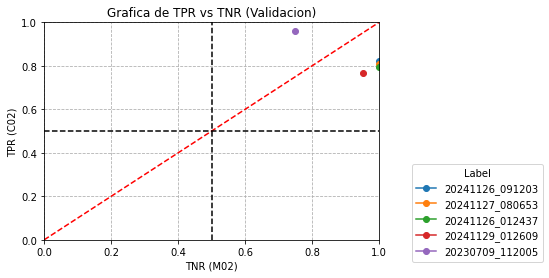

HIPERPARAMETROS UNICOS...
                          VALORES
P-loss        binary_crossentropy
P-normLayer                  True
P-dense_tipo                 RELU
P-canales                       3
2521


,idTest,epoca,TNR,TPR,acc_bal,train_TNR,train_TPR,train_acc_bal,FDR_FOR,P-inputs,...,P-droupout,P-maxPool,P-rnn_tipo,P-rnn_units,P-dense_cant,P-dense_units,P-kernel_regularizer,P-dense_droupout,P-tiempos,P-margen
406,20241126_091203,185,1.0,0.822014,0.911007,0.848958,0.85625,0.852604,0.475,"['imagen', '_dato', '_umb1', '_altura']",...,"[0.1, 0.3, 0.2, 0.2, 0.1, 0.1]","[False, False, False, False, False, False]",CONV3D,16,4,"[64, 32, 16, 8]","[0, 0, 0, 0]","[0.3, 0.2, 0.1, 0]",6,12
598,20241127_080653,177,1.0,0.809524,0.904762,0.865625,0.857292,0.861458,0.476562,"['imagen', '_dato', '_umb1', '_altura']",...,"[0.1, 0.3, 0.2, 0.2, 0.1, 0.1]","[False, False, False, False, False, False]",CONV3D,16,4,"[64, 32, 16, 8]","[0, 0, 0, 0]","[0.3, 0.2, 0.1, 0]",6,12
178,20241126_012437,157,1.0,0.79313,0.896565,0.916667,0.822917,0.869792,0.478339,"['imagen', '_dato', '_umb1', '_altura']",...,"[0.1, 0.3, 0.2, 0.2, 0.1, 0.1]","[False, False, False, False, False, False]",CONV3D,8,4,"[64, 32, 16, 8]","[0, 0, 0, 0]","[0.3, 0.2, 0.1, 0]",6,10
4715,20241129_012609,143,0.953488,0.766273,0.859881,0.91129,0.854839,0.883065,0.447976,"['imagen', '_dato', '_umb1', '_altura']",...,"[0.1, 0.3, 0.2, 0.2, 0.1, 0.1]","[False, False, False, False, False, False]",LSTM,8,4,"[64, 32, 16, 8]","[0, 0, 0, 0]","[0.3, 0.2, 0.1, 0]",6,10
5071,20230709_112005,99,0.75,0.959407,0.854703,0.433333,0.965625,0.699479,0.427447,"['imagen', 'dato', 'umb1', 'altura']",...,"[0.2, 0.3]","[False, False]",LSTM,64,2,"[128, 64]",0,0,3,10
4117,20241030_101704,145,0.911111,0.792616,0.851864,0.892127,0.870793,0.88146,0.470969,"['imagen', '_dato', '_umb1', '_altura']",...,"[0.1, 0.3, 0.2, 0.2, 0.1, 0.1]","[False, False, False, False, False, False]",LSTM,16,4,"[64, 32, 16, 8]","[0, 0, 0, 0]","[0.3, 0.2, 0.1, 0]",6,12
10911,20240403_144912,11,0.75,0.952381,0.85119,0.145833,0.489583,0.317708,0.436941,"['imagen', 'dato', 'umb1', 'altura']",...,"[0.2, 0.1, 0.2, 0.1]","[False, False, False, False]",LSTM,16,4,"[128, 64, 32, 16]",0,0,5,8
10668,20240403_033405,21,0.75,0.949258,0.849629,0.042708,0.578125,0.310417,0.44042,"['imagen', 'dato', 'umb1', 'altura']",...,"[0.2, 0.1, 0.2, 0.1]","[False, False, False, False]",LSTM,16,4,"[128, 64, 32, 16]",0,0,5,4
8028,20240325_231109,86,0.75,0.947697,0.848849,0.314583,0.958333,0.636458,0.442022,"['imagen', 'dato', 'umb1', 'altura']",...,"[0.2, 0.1, 0.2, 0.1]","[False, False, False, False]",LSTM,32,3,"[128, 64, 32]",0,0,6,10
11510,20240404_050409,241,0.75,0.942233,0.846116,0.321875,0.986458,0.654167,0.447023,"['imagen', 'dato', 'umb1', 'altura']",...,"[0.2, 0.1, 0.2, 0.1]","[False, False, False, False]",LSTM,16,4,"[128, 64, 32, 16]",0,0,4,8


In [16]:
params = {
    # General
    'resultDir': f'{path_base}/Archivos/Resultados/Clasificacion', # Direcotrio de resultados    
    'redoStats': True, #True, #True,        # True : Rehace las estadisticas, caso contrario solo lee los archivos de reportes
    'drop'     : ['idTest',['20240326_224209', '20240326_050743']], #['idTest',['20240326_224209', '20230710_181720']],#['P-rnn_tipo',['LSTM']],    'idTest', ['20230706_044401']
    'select'   : ['P-dsTName' , ['CLASE_TrainDS_3','XXXXX_V2','CLASE_TrainDS_1']], #['P-dsTName' , ['XXXXX_V2']], #['P-dsTName' , ['CLASE_TrainDS_3']],
       
    # Stats
    'model'    : 'Clasificacion',  
    'criterio' : 'acc_bal',       # avg_acc_bal Para filtrar el mejor modelo de las epocas en cada test
    'ascending': False,           # True = Max segun el criterio
    'filterHP' : True,            # Muestra solo las columnas de HP que varia
    
    # Graficas
    'grafica'  : True,
    'train'    : False,
    'maxNum'   : 5,              # 0 = TODOS los modelos
}


bestResults = summaryStats(path_base, params)
print(len(bestResults))
bestResults.head(10)#[(bestResults['TNR']!=0) & (bestResults['TPR']!=0)].head(30)

In [17]:
#bestResults[['idTest', 'epoca', 'TNR', 'TPR', 'acc_bal', 'train_TNR', 'train_TPR',
#       'train_acc_bal','P-inputs','P-rnn_tipo']].groupby(['idTest','P-rnn_tipo', 'acc_bal']).max().head(20).sort_values('acc_bal', ascending=False)#

Se va rehacer el dataset....


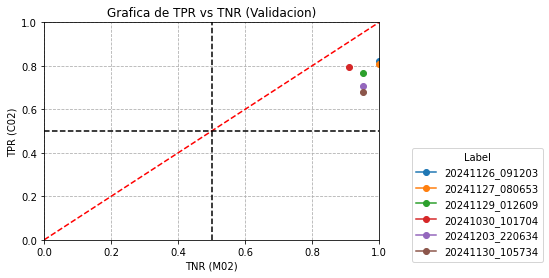

HIPERPARAMETROS UNICOS...
                           VALORES
P-loss         binary_crossentropy
P-normLayer                   True
P-pre_trained                   []
P-dense_tipo                  RELU
P-canales                        3
1132


,idTest,epoca,TNR,TPR,acc_bal,train_TNR,train_TPR,train_acc_bal,FDR_FOR,P-inputs,...,P-droupout,P-maxPool,P-rnn_tipo,P-rnn_units,P-dense_cant,P-dense_units,P-kernel_regularizer,P-dense_droupout,P-tiempos,P-margen
406,20241126_091203,185,1.0,0.822014,0.911007,0.848958,0.85625,0.852604,0.475,"['imagen', '_dato', '_umb1', '_altura']",...,"[0.1, 0.3, 0.2, 0.2, 0.1, 0.1]","[False, False, False, False, False, False]",CONV3D,16,4,"[64, 32, 16, 8]","[0, 0, 0, 0]","[0.3, 0.2, 0.1, 0]",6,12
598,20241127_080653,177,1.0,0.809524,0.904762,0.865625,0.857292,0.861458,0.476562,"['imagen', '_dato', '_umb1', '_altura']",...,"[0.1, 0.3, 0.2, 0.2, 0.1, 0.1]","[False, False, False, False, False, False]",CONV3D,16,4,"[64, 32, 16, 8]","[0, 0, 0, 0]","[0.3, 0.2, 0.1, 0]",6,12
5515,20241129_012609,143,0.953488,0.766273,0.859881,0.91129,0.854839,0.883065,0.447976,"['imagen', '_dato', '_umb1', '_altura']",...,"[0.1, 0.3, 0.2, 0.2, 0.1, 0.1]","[False, False, False, False, False, False]",LSTM,8,4,"[64, 32, 16, 8]","[0, 0, 0, 0]","[0.3, 0.2, 0.1, 0]",6,10
4917,20241030_101704,145,0.911111,0.792616,0.851864,0.892127,0.870793,0.88146,0.470969,"['imagen', '_dato', '_umb1', '_altura']",...,"[0.1, 0.3, 0.2, 0.2, 0.1, 0.1]","[False, False, False, False, False, False]",LSTM,16,4,"[64, 32, 16, 8]","[0, 0, 0, 0]","[0.3, 0.2, 0.1, 0]",6,12
2486,20241203_220634,175,0.953488,0.706239,0.829864,0.935484,0.703293,0.819388,0.457931,"['imagen', '_dato', '_umb1', '_altura']",...,"[0.1, 0.3, 0.2, 0.1, 0.1]","[False, False, False, False, False]",CONV3D,8,4,"[64, 32, 16, 8]","[0, 0, 0, 0]","[0.3, 0.2, 0.1, 0]",6,12


In [32]:
params = {
    # General
    'resultDir': f'{path_base}/Archivos/Resultados/Clasificacion', # Direcotrio de resultados    
    'redoStats': True, #True, #True,        # True : Rehace las estadisticas, caso contrario solo lee los archivos de reportes
    'drop'     : ['idTest',['20241126_012437','20240326_224209', '20240326_050743']], #['idTest',['20240326_224209', '20230710_181720']],#['P-rnn_tipo',['LSTM']],    'idTest', ['20230706_044401']
    'select'   :['P-dsTName' , ['CLASE_TrainDS_1']], #['P-dsTName' , ['XXXXX_V2']], #['P-dsTName' , ['CLASE_TrainDS_3']],
       
    # Stats
    'model'    : 'Clasificacion',  
    'criterio' : 'acc_bal',       # avg_acc_bal Para filtrar el mejor modelo de las epocas en cada test
    'ascending': False,           # True = Max segun el criterio
    'filterHP' : True,            # Muestra solo las columnas de HP que varia
    
    # Graficas
    'grafica'  : True,
    'train'    : False,
    'maxNum'   : 6,              # 0 = TODOS los modelos
}


bestResults = summaryStats(path_base, params)
print(len(bestResults))
bestResults.head(5)#[(bestResults['TNR']!=0) & (bestResults['TPR']!=0)].head(30)

In [33]:
bestResults[bestResults['idTest']=='20241129_012609'].to_dict()

{'idTest': {5515: '20241129_012609'},
 'epoca': {5515: 143},
 'TNR': {5515: 0.9534883720930233},
 'TPR': {5515: 0.7662731871838111},
 'acc_bal': {5515: 0.8598807796384171},
 'train_TNR': {5515: 0.9112903225806451},
 'train_TPR': {5515: 0.8548387096774194},
 'train_acc_bal': {5515: 0.8830645161290323},
 'FDR_FOR': {5515: 0.4479755088156925},
 'P-inputs': {5515: "['imagen', '_dato', '_umb1', '_altura']"},
 'P-optimizer': {5515: 'Adam'},
 'P-lr_schedule': {5515: 0.0},
 'P-lr_decay': {5515: 0.94},
 'P-lr': {5515: 0.001},
 'P-batchNorm': {5515: True},
 'P-cnn_cant': {5515: 6},
 'P-cnn_units': {5515: '[16, 32, 64, 32, 16, 8]'},
 'P-droupout': {5515: '[0.1, 0.3, 0.2, 0.2, 0.1, 0.1]'},
 'P-maxPool': {5515: '[False, False, False, False, False, False]'},
 'P-rnn_tipo': {5515: 'LSTM'},
 'P-rnn_units': {5515: 8},
 'P-dense_cant': {5515: 4},
 'P-dense_units': {5515: '[64, 32, 16, 8]'},
 'P-kernel_regularizer': {5515: '[0, 0, 0, 0]'},
 'P-dense_droupout': {5515: '[0.3, 0.2, 0.1, 0]'},
 'P-tiempos': 

In [20]:
1228/(1228+53),9/12

(0.9586260733801717, 0.75)

In [21]:
(0.958626073380171+0.75)/2

0.8543130366900855

In [22]:
bestResults[['idTest', 'epoca', 'TNR', 'TPR', 'acc_bal', 'train_TNR', 'train_TPR',
       'train_acc_bal','P-inputs','P-rnn_tipo']].groupby(['idTest','P-rnn_tipo']).max().head(20).sort_values('acc_bal', ascending=False)

,,epoca,TNR,TPR,acc_bal,train_TNR,train_TPR,train_acc_bal,P-inputs
idTest,P-rnn_tipo,,,,,,,,
20240924_235431,LSTM,62,0.866667,0.589085,0.727876,0.624099,0.667668,0.645883,"['imagen', 'dato', 'umb1', 'altura']"
20240927_152142,CONV3D,97,0.733333,0.708507,0.720920,0.256010,0.733774,0.494892,"['imagen', 'dato', 'umb1', 'altura']"
20240923_101614,LSTM,129,0.866667,0.573355,0.720011,0.636118,0.617188,0.626653,"['imagen', 'dato', 'umb1', 'altura']"
20240926_181051,CONV3D,81,0.866667,0.569181,0.717924,0.292067,0.738281,0.515174,"['imagen', 'dato', 'umb1', 'altura']"
20241004_070526,LSTM,27,0.888889,0.546067,0.717478,0.748798,0.490685,0.619742,"['imagen', '_dato', '_umb1', '_altura']"
20240926_230328,CONV3D,26,0.955556,0.446228,0.700892,0.655048,0.608774,0.631911,"['imagen', 'dato', 'umb1', 'altura']"
20240926_093952,CONV3D,110,0.955556,0.444623,0.700089,0.657452,0.586839,0.622145,"['imagen', 'dato', 'umb1', 'altura']"
20240926_012637,CONV3D,46,1.000000,0.088283,0.544141,0.118690,0.981671,0.550180,"['imagen', 'dato', 'umb1', 'altura']"
20240924_043001,LSTM,137,0.111111,0.971108,0.541109,0.083233,0.987981,0.535607,"['imagen', 'dato', 'umb1', 'altura']"


Se va rehacer el dataset....


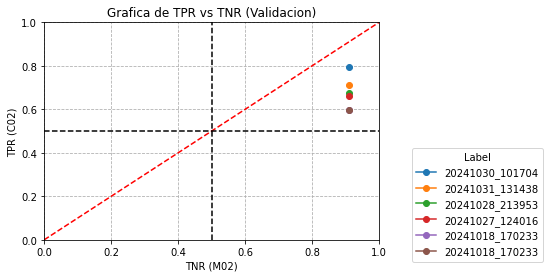

HIPERPARAMETROS UNICOS...
                           VALORES
P-loss         binary_crossentropy
P-normLayer                   True
P-pre_trained                   []
P-dense_tipo                  RELU
P-canales                        3
1122


,idTest,epoca,TNR,TPR,acc_bal,train_TNR,train_TPR,train_acc_bal,FDR_FOR,P-inputs,...,P-rnn_units,P-dense_cant,P-dense_units,P-tiempos,P-margen,P-dense_droupout,P-optimizer,P-lr_schedule,P-kernel_regularizer,P-lr_decay
3496,20241030_101704,145,0.911111,0.792616,0.851864,0.892127,0.870793,0.88146,0.470969,"['imagen', '_dato', '_umb1', '_altura']",...,16,4,"[64, 32, 16, 8]",6,12,"[0.3, 0.2, 0.1, 0]",Adam,0.0,"[0, 0, 0, 0]",0.94
3690,20241031_131438,139,0.911111,0.71236,0.811735,0.866587,0.844651,0.855619,0.479021,"['imagen', '_dato', '_umb1', '_altura']",...,8,4,"[64, 32, 16, 8]",6,12,"[0.3, 0.2, 0.1, 0]",Adam,0.0,"[0, 0, 0, 0]",0.94
1684,20241028_213953,194,0.911111,0.675441,0.793276,0.91887,0.783654,0.851262,0.481462,"['imagen', '_dato', '_umb1', '_altura']",...,16,4,"[64, 32, 16, 8]",6,12,"[0.3, 0.2, 0.1, 0]",Adam,0.0,"[0, 0, 0, 0]",0.94
1451,20241027_124016,161,0.911111,0.663242,0.787177,0.920072,0.688101,0.804087,0.482159,"['imagen', '_dato', '_umb1', '_altura']",...,16,4,"[64, 32, 16, 8]",6,12,"[0.3, 0.2, 0.1, 0]",Adam,0.0,"[0, 0, 0, 0]",0.94
3042,20241018_170233,91,0.911111,0.599037,0.755074,0.838942,0.601262,0.720102,0.485178,"['imagen', '_dato', '_umb1', '_altura']",...,16,4,"[64, 32, 16, 8]",6,8,"[0.3, 0.2, 0.1, 0]",Adam,0.1,"[0, 0, 0, 0]",0.0
3039,20241018_170233,88,0.911111,0.599037,0.755074,0.836839,0.597356,0.717097,0.485178,"['imagen', '_dato', '_umb1', '_altura']",...,16,4,"[64, 32, 16, 8]",6,8,"[0.3, 0.2, 0.1, 0]",Adam,0.1,"[0, 0, 0, 0]",0.0
3040,20241018_170233,89,0.911111,0.599037,0.755074,0.836839,0.598558,0.717698,0.485178,"['imagen', '_dato', '_umb1', '_altura']",...,16,4,"[64, 32, 16, 8]",6,8,"[0.3, 0.2, 0.1, 0]",Adam,0.1,"[0, 0, 0, 0]",0.0
4381,20240924_235431,62,0.866667,0.589085,0.727876,0.624099,0.667668,0.645883,0.486846,"['imagen', 'dato', 'umb1', 'altura']",...,16,4,"[128, 64, 32, 16]",6,12,0,0,0.0,0,0.0
2367,20240927_152142,97,0.733333,0.708507,0.72092,0.25601,0.733774,0.494892,0.485169,"['imagen', 'dato', 'umb1', 'altura']",...,16,4,"[128, 64, 32, 16]",6,8,0,0,0.0,0,0.0
4152,20240923_101614,129,0.866667,0.573355,0.720011,0.636118,0.617188,0.626653,0.48742,"['imagen', 'dato', 'umb1', 'altura']",...,16,4,"[128, 64, 32, 16]",6,8,0,0,0.0,0,0.0


In [22]:
params = {
    # General
    'resultDir': f'{path_base}/Archivos/Resultados/Clasificacion', # Direcotrio de resultados    
    'redoStats': True, #True, #True,        # True : Rehace las estadisticas, caso contrario solo lee los archivos de reportes
    'drop'     : ['idTest',['20240326_224209', '20240326_050743']], #['idTest',['20240326_224209', '20230710_181720']],#['P-rnn_tipo',['LSTM']],    'idTest', ['20230706_044401']
    'select'   :['P-dsTName' , ['CLASE_TrainDS_1']], #['P-dsTName' , ['XXXXX_V2']], #['P-dsTName' , ['CLASE_TrainDS_3']],
       
    # Stats
    'model'    : 'Clasificacion',  
    'criterio' : 'acc_bal',       # avg_acc_bal Para filtrar el mejor modelo de las epocas en cada test
    'ascending': False,           # True = Max segun el criterio
    'filterHP' : True,            # Muestra solo las columnas de HP que varia
    
    # Graficas
    'grafica'  : True,
    'train'    : False,
    'maxNum'   : 6,              # 0 = TODOS los modelos
}


bestResults = summaryStats(path_base, params)
print(len(bestResults))
bestResults.head(15)#[(bestResults['TNR']!=0) & (bestResults['TPR']!=0)].head(30)

In [23]:
a = '

SyntaxError: EOL while scanning string literal (2754607837.py, line 1)

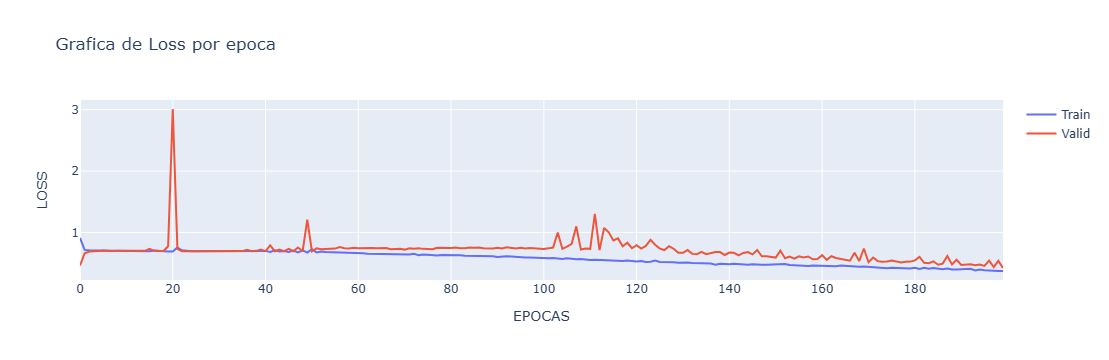

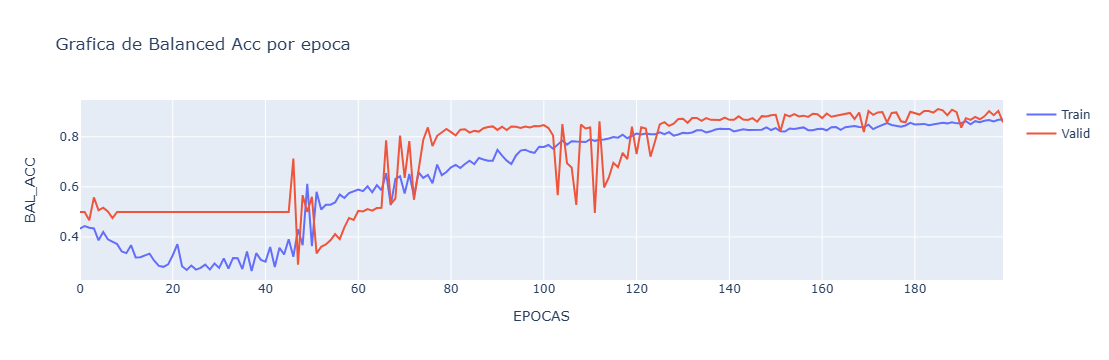

In [36]:
analizarProject(path_base, '20241126_091203')

In [18]:
raise Exception('Hola')

Exception: Hola

In [19]:
bestResults[bestResults['idTest'] == '20241027_124016'].head(1).to_dict()

{'idTest': {1451: '20241027_124016'},
 'epoca': {1451: 161},
 'TNR': {1451: 0.9111111111111111},
 'TPR': {1451: 0.6632423756019261},
 'acc_bal': {1451: 0.7871767433565187},
 'train_TNR': {1451: 0.9200721153846154},
 'train_TPR': {1451: 0.6881009615384616},
 'train_acc_bal': {1451: 0.8040865384615385},
 'FDR_FOR': {1451: 0.48215884412533794},
 'P-inputs': {1451: "['imagen', '_dato', '_umb1', '_altura']"},
 'P-lr': {1451: 0.001},
 'P-batchNorm': {1451: True},
 'P-cnn_cant': {1451: 6},
 'P-cnn_units': {1451: '[16, 32, 64, 32, 16, 8]'},
 'P-droupout': {1451: '[0.1, 0.3, 0.2, 0.2, 0.1, 0.1]'},
 'P-maxPool': {1451: '[False, False, False, False, False, False]'},
 'P-rnn_tipo': {1451: 'CONV3D'},
 'P-dense_cant': {1451: 4},
 'P-dense_units': {1451: '[64, 32, 16, 8]'},
 'P-tiempos': {1451: 6},
 'P-margen': {1451: 12},
 'P-dense_droupout': {1451: '[0.3, 0.2, 0.1, 0]'},
 'P-optimizer': {1451: 'Adam'},
 'P-lr_schedule': {1451: 0.0},
 'P-kernel_regularizer': {1451: '[0, 0, 0, 0]'},
 'P-lr_decay': {1

In [ ]:
a = [
 'P-extra_inputs' , #'P-inputs',
 'P-lr',
 ##'P-normLayer', 
 ##'P-pre_trained', 
 'P-cnn_units', 
 #'P-cnn_cant', 
 'P-rnn_units', # -
 #'P-dense_cant',
 'P-dense_units',
 'P-time_frames', #'P-tiempos',
 'P-size_-window (px)', #'P-margen',
 ##'acc_bal'
]

In [ ]:
bestResults['P-inputs'].unique()

In [ ]:
bestResults.rename(columns={'P-tiempos': 'P-time_frames'}, inplace=True)
bestResults.rename(columns={'P-tiempos': 'P-time_frames'}, inplace=True)
bestResults.rename(columns={'P-margen': 'P-size_-window (px)'}, inplace=True)
bestResults.rename(columns={'P-inputs': 'P-extra_inputs'}, inplace=True)
valores_a_reemplazar = {"['imagen', 'dato', 'umb1', 'altura']" : "['stat90', 'altitude']" , 
                        "['imagen', 'dato', 'altura']" : "['altitude']" ,
                        "['imagen', 'dato', 'umb1']" : "['stat90']",
                       }
bestResults['P-extra_inputs'] = bestResults['P-extra_inputs'].replace(valores_a_reemplazar)

In [ ]:
def plotly_parallel_coordinates(df, cols=[], color='acc_bal'):
    if not cols:
        cols =  [x for x in df.columns if ('__' in x) and (x != 'acc_bal')]
    
    data = []
    for col in cols:
        try:
            df[f'__{col}'] = df[col].astype(float)
            
            text_values = list(df[f'__{col}'].unique())
            original_values = list(df[f'{col}'].unique())
        except ValueError:
            uniques_values = list(df[col].unique())
            df[f'__{col}'] = df[col].apply(lambda x : uniques_values.index(x))    
            
            text_values = [x for x in range(len(uniques_values))]
            original_values = list(df[f'{col}'].unique())
            
        dict_values = {
            'label' : col,
            'range' : [df[f'__{col}'].min(), df[f'__{col}'].max()],
            'values' : df[f'__{col}'],     
            
            'tickvals' : text_values, #[1,2,4,5],
            'ticktext' : original_values, #['text 1', 'text 2', 'text 3', 'text 4']
            
        }
        data.append(dict_values)
        
    fig = go.Figure(data=
        go.Parcoords(            
            line = dict(color = df[color],
                   #colorscale = 'Electric',
                   showscale = True,
                   cmin = df[color].min(),
                   cmax = df[color].max()),
            dimensions = data)
    )
    
    
   
    fig.update_layout(
        width=100,
        font=dict(size=20),  # Tamaño general de la fuente
        #title=dict(text='Gráfico de Coordenadas Paralelas', font=dict(size=20)),  # Tamaño del título
        margin=dict(l=60, r=10, t=40, b=10)  # Ajustar márgenes
    )
    
    fig.show()
plotly_parallel_coordinates(bestResults, cols=a, color='acc_bal')

In [ ]:
len(bestResults['idTest'].unique())

In [ ]:
plotly_parallel_coordinates(bestResults, cols=a, color='acc_bal')

In [ ]:
bestResults['idTest'].nunique()

In [ ]:
bestResults

In [ ]:
#cols = [x for x in _data.columns if ('__' in x) and (x != '__acc_bal')]
#fig = px.parallel_coordinates(_data, color="__acc_bal",
#                              dimensions=cols)
#fig.show()

In [ ]:
bestResults[bestResults['idTest']=='20240326_224209'].to_dict()

In [ ]:
import pickle

In [ ]:
df = pd.read_csv(f'{path_base}/Archivos/Reportes/Entrenamiento/Clasificacion/Reporte-TOTAL.csv')  
df.columns

In [ ]:
df[df['idTest']=='20230709_112005'][['loss', 'acc', 'TP', 'TN', 'FP', 'FN', 'val_loss',
       'val_acc', 'val_TP', 'val_TN', 'val_FP', 'val_FN', 'epoca', 'idTest',
       'idProject', 'directory', 'P-dsTName']].tail(1)

In [ ]:
df[df['idTest']=='20230710_224918'][['loss', 'acc', 'TP', 'TN', 'FP', 'FN', 'val_loss',
       'val_acc', 'val_TP', 'val_TN', 'val_FP', 'val_FN', 'epoca', 'idTest',
       'idProject', 'directory', 'P-dsTName']].tail(1)

In [ ]:
"""
Analizamos un proyecto de clasifiacion a mas detalle
"""

In [ ]:
analizarProject(path_base, '20240924_235431')

In [ ]:
data = bestResults.copy()
data.loc[data['P-inputs'] == "['imagen', 'umb1', 'dato', 'altura']", 'P-inputs'] = "['imagen', 'dato', 'umb1', 'altura']"
data['P-inputs'] = data['P-inputs'].str.replace("'imagen', 'dato'","+")
#data = data.drop(['P-droupout','P-maxPool','P-cnn_units','P-cnn_cant'], axis=1)

col = [e for e in data.columns if 'P-' in e]
col.append('acc_bal')
_data = data[col]

def groupAcc(x):
    if x < 0.6:
        return 0
    elif x < 0.7:
        return 1
    else:
        return 2

    
_data['Acc'] = _data['acc_bal'].apply(lambda x : groupAcc(x))

In [ ]:
_data['acc_bal'].max()

In [ ]:
a = [
#'P-inputs',
 'P-lr',
 'P-normLayer',
 'P-cnn_units',
 #'P-droupout',
 #'P-maxPool',
 #'P-rnn_tipo',
 #'P-rnn_units',
 #'P-dense_cant',
 #'P-dense_units',
 'P-tiempos',
 'P-margen',
# 'acc_bal'
]
#col[:-1]

In [ ]:
fig = px.parallel_categories(_data, color='Acc', dimensions=col[:-1],  color_continuous_scale=px.colors.diverging.Fall)
fig.show()

In [ ]:
fig = px.parallel_categories(_data, color='Acc', dimensions=a,  color_continuous_scale=px.colors.diverging.Fall)
fig.show()

In [ ]:


cars_df = data#pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/imports-85.csv')

col = [e for e in data.columns if 'P-' in e]

# Build parcats dimensions
categorical_dimensions = col

dimensions = [dict(values=cars_df[label], label=label) for label in categorical_dimensions]

# Build colorscale
color = np.zeros(len(cars_df), dtype='uint8')
colorscale = [[0, 'gray'], [0.33, 'gray'],
              [0.33, 'firebrick'], [0.66, 'firebrick'],
              [0.66, 'blue'], [1.0, 'blue']]
cmin = -0.5
cmax = 2.5

# Build figure as FigureWidget
fig = go.FigureWidget(
    data=[go.Scatter(x=cars_df['TNR'], y=cars_df['TPR'],
                marker={'color': color, 'cmin': cmin, 'cmax': cmax,
                        'colorscale': colorscale, 'showscale': True,
                        'colorbar': {'tickvals': [0, 1, 2], 'ticktext': ['None', 'Red', 'Blue']}},
                     mode='markers'),

          go.Parcats(domain={'y': [0.3, 0.5]}, dimensions=dimensions,
                   line={'colorscale': colorscale, 'cmin': cmin,
                         'cmax': cmax, 'color': color, 'shape': 'hspline'}),
         go.Table(domain={'y': [0, 0.28]}, header=dict(values=data.columns),
                 cells=dict(values=[[0]]*len(data.columns), format = [".2f"])
                 )],
    layout = {
        'shapes': [
            # Line Horizontal
            {
                'type': 'line','x0': 0,'y0': 0.5,'x1': 1,'y1': 0.5,'line': {'color': 'rgb(50, 171, 96)','width': 1},
            },
            {
                'type': 'line','x0': 0.5,'y0': 0,'x1': 0.5 ,'y1': 1,'line': {'color': 'rgb(50, 171, 96)','width': 1},
            },
            {
                'type': 'line','x0': 0,'y0': 0,'x1': 1 ,'y1': 1,'line': {'color': 'rgb(50, 171, 96)','width': 1},
            }
        ],
    'showlegend': False
}
    
)

fig.update_layout(title={'text':'TNP VS TNR DE ESTADISTICAS DE VALIDACION'},height=1000, xaxis={'title': 'TNR', 'domain': [0.1,0.9]},
                  yaxis={'title': 'TPR', 'domain': [0.6, 1]},
                  dragmode='lasso', hovermode='closest', yaxis_range=[0,1], xaxis_range=[0,1])

# Build color selection widget
color_toggle = widgets.ToggleButtons(
    options=['None', 'Red', 'Blue'],
    index=1, description='Brush Color:', disabled=False)

# Update color callback
def update_color(trace, points, state):
    # Compute new color array
    new_color = np.array(fig.data[0].marker.color)
    new_color[points.point_inds] = color_toggle.index
    #print(points)
    with fig.batch_update():
        # Update scatter color
        fig.data[0].marker.color = new_color

        # Update parcats colors
        fig.data[1].line.color = new_color
        
        # Update table
        tx = data.iloc[points.point_inds]
        fig.data[2].cells =  dict(values= tx.T, format= ["","",".2f",".2f",".2f",".2f",".2f",".2f",""])

# Register callback on scatter selection...
fig.data[0].on_selection(update_color)
# and parcats click
fig.data[1].on_click(update_color)

# Display figure
widgets.VBox([color_toggle, fig])
